In [1]:
import pandas as pd

def read_data(year, month, categorical):
    url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet'
    df = pd.read_parquet(url, engine='pyarrow')
    if categorical:
        df['passenger_count'] = df['passenger_count'].astype('category')
    return df

def main(year, month, categorical):
    # Perform refactored tasks here
    df = read_data(year, month, categorical)

    # Example processing
    # Replace with your actual processing logic
    print(f"Data loaded for {year}-{month:02}")
    print(df.head())

    # Example output to local filesystem
    output_file = f'taxi_type=yellow_year={year:04d}_month={month:02d}.parquet'
    df.to_parquet(output_file, engine='pyarrow')

if __name__ == "__main__":
    year = 2023
    month = 3
    categorical = True  # Adjust based on your needs

    main(year, month, categorical)


Data loaded for 2023-03
   VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count  \
0         2  2023-03-01 00:06:43   2023-03-01 00:16:43             1.0   
1         2  2023-03-01 00:08:25   2023-03-01 00:39:30             2.0   
2         1  2023-03-01 00:15:04   2023-03-01 00:29:26             0.0   
3         1  2023-03-01 00:49:37   2023-03-01 01:01:05             1.0   
4         2  2023-03-01 00:08:04   2023-03-01 00:11:06             1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.00         1.0                  N           238            42   
1          12.40         1.0                  N           138           231   
2           3.30         1.0                  N           140           186   
3           2.90         1.0                  N           140            43   
4           1.23         1.0                  N            79           137   

   payment_type  fare_amount  extra  mta_tax  tip_amount

Q1. Refactoring
Before we can start covering our code with tests, we need to refactor it. We'll start by getting rid of all the global variables.

Let's create a function main with two parameters: year and month.
Move all the code (except read_data) inside main
Make categorical a parameter for read_data and pass it inside main
Now we need to create the "main" block from which we'll invoke the main function. How does the if statement that we use for this looks like?

Hint: after refactoring, check that the code still works. Just run it e.g. for March 2023 and see if it finishes successfully.

To make it easier to run it, you can write results to your local filesystem. E.g. here:

output_file = f'taxi_type=yellow_year={year:04d}_month={month:02d}.parquet'


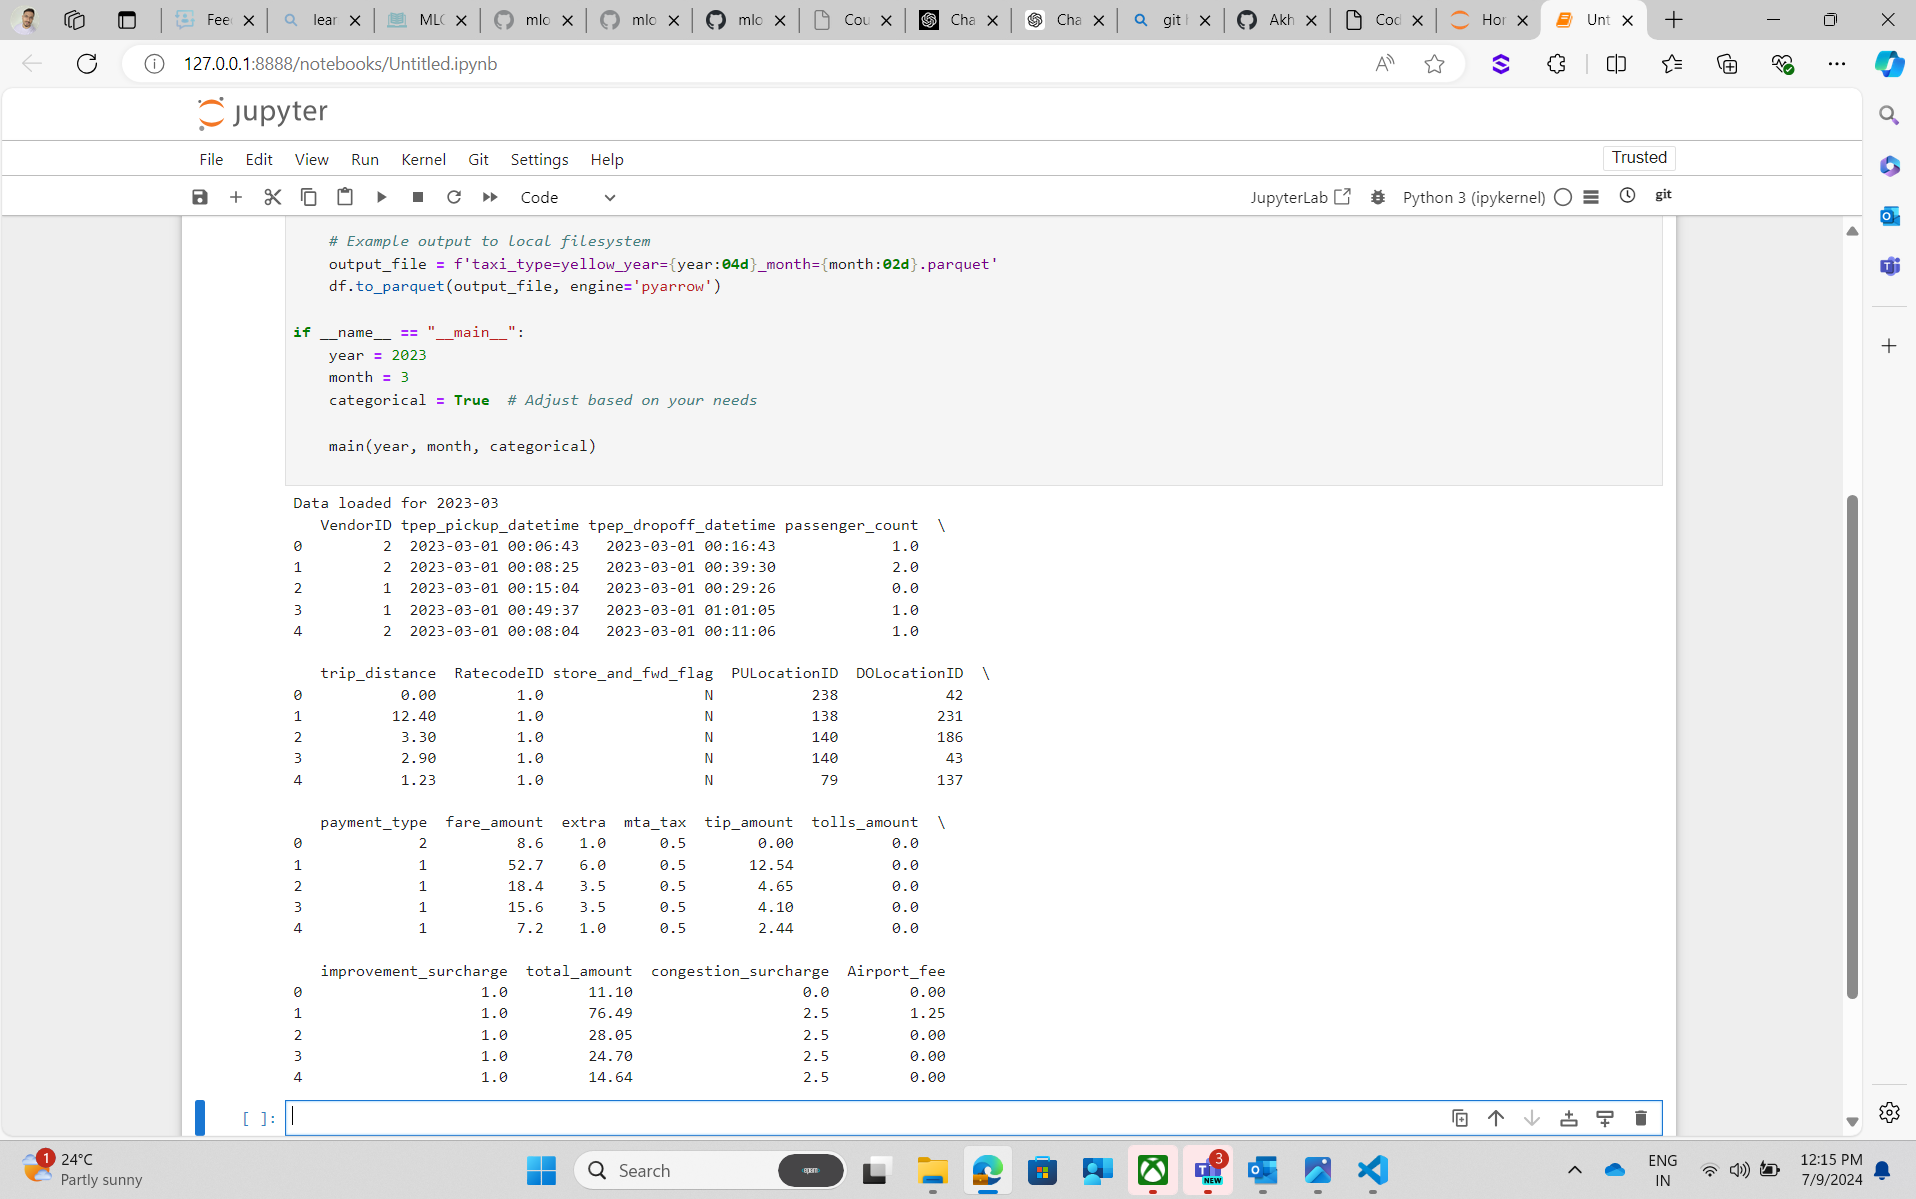

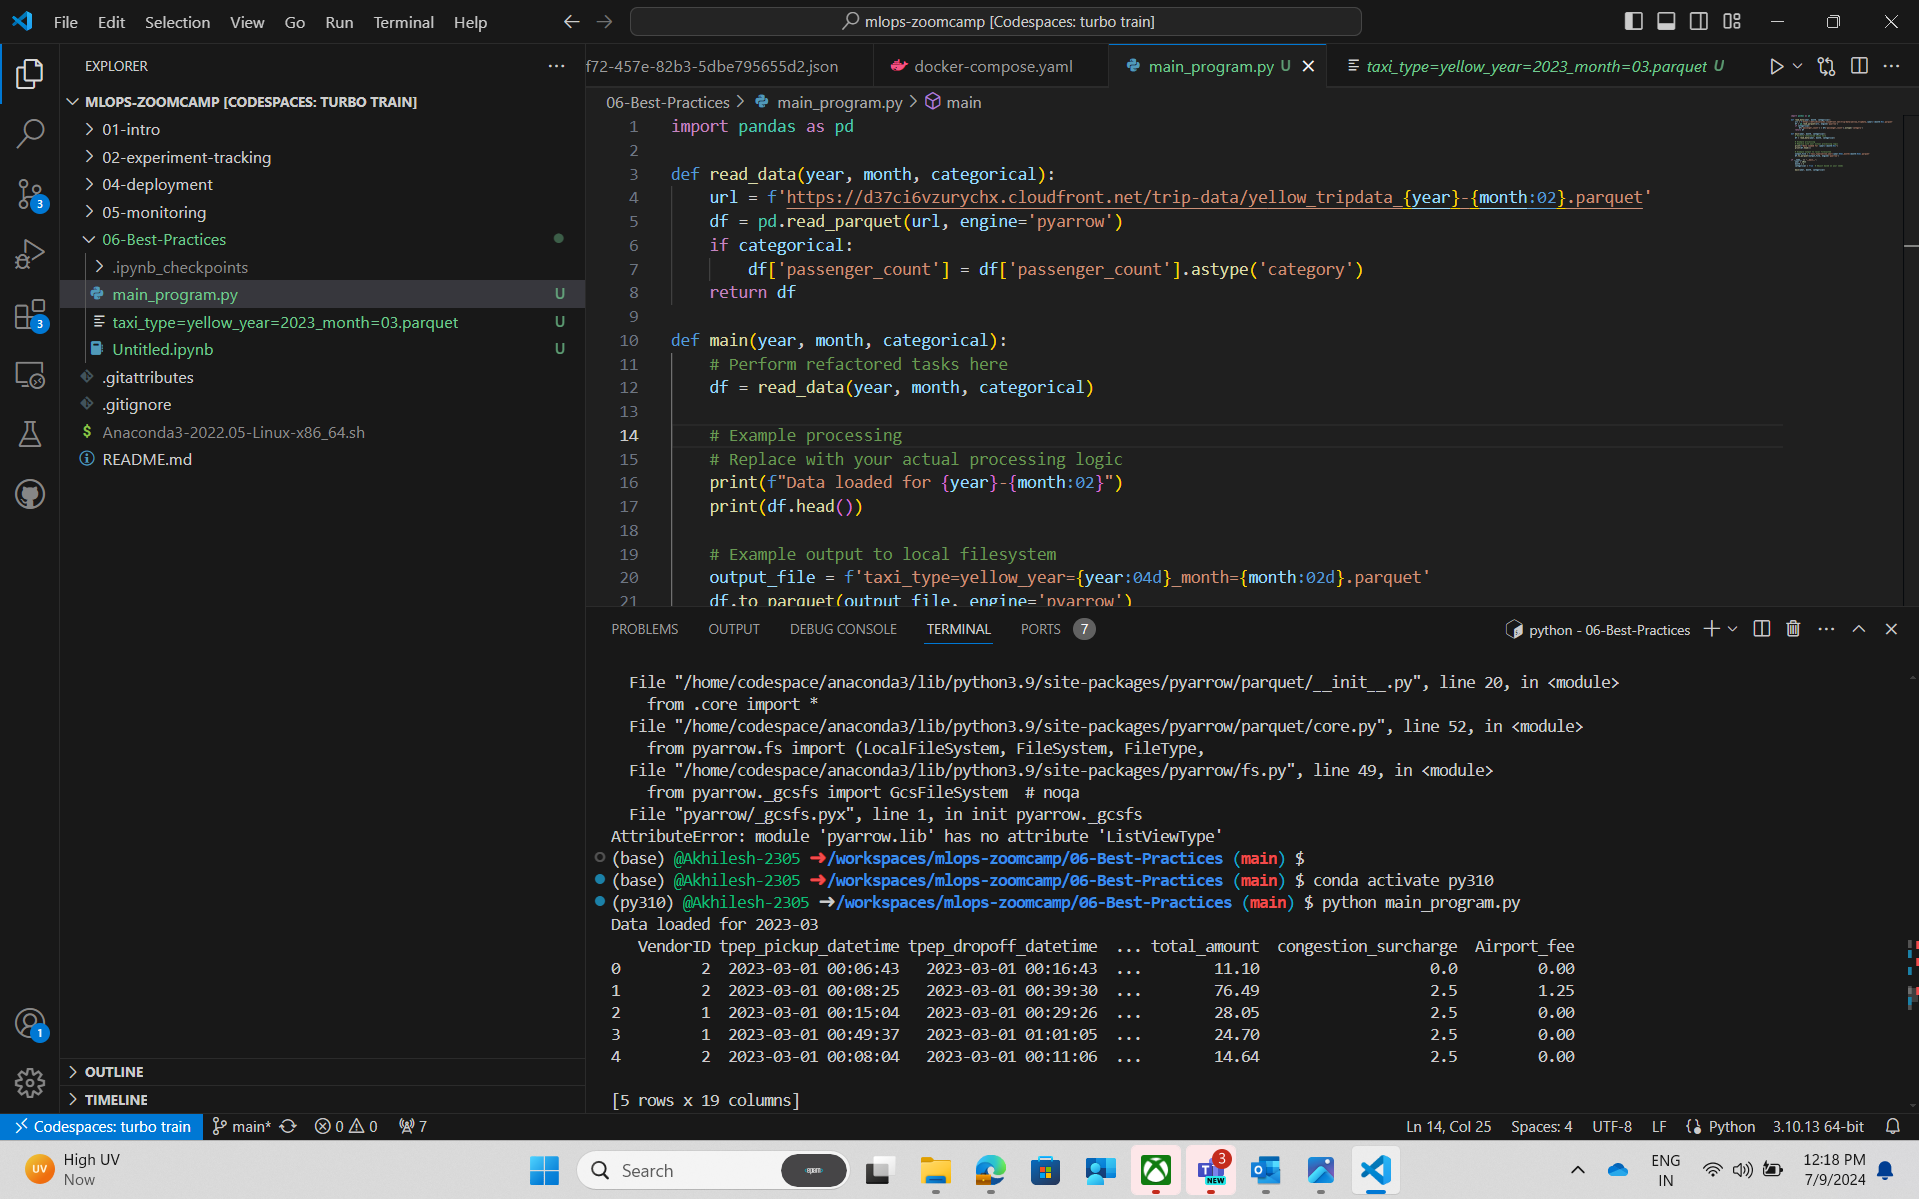

Answer: if __name__ == "__main__":
    year = 2023
    month = 3
    categorical = True

In [2]:
!pwd

/workspaces/mlops-zoomcamp/06-Best-Practices


In [3]:
import pandas as pd
from datetime import datetime

def dt(hour, minute, second=0):
    return datetime(2021, 1, 1, hour, minute, second)

data = [
    (None, None, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2, 0), dt(1, 2, 50)),
    (1, 1, dt(1, 2, 0), dt(2, 2, 1)),        
]

data = [
    (None, None, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2), dt(1, 10)),
    (1, 1, dt(1, 2, 0), dt(1, 2, 50)),
    (1, 1, dt(1, 2, 0), dt(2, 2, 1)),
    ]



columns = ['PUlocationID', 'DOlocationID', 'pickup_datetime', 'dropOff_datetime']
df = pd.DataFrame(data, columns=columns)

In [4]:
df.to_parquet("input_unit_test.parquet", engine='pyarrow', index=False)

In [5]:
df.head()

,PUlocationID,DOlocationID,pickup_datetime,dropOff_datetime
0,NaN,NaN,2021-01-01 01:02:00,2021-01-01 01:10:00
1,1.0,1.0,2021-01-01 01:02:00,2021-01-01 01:10:00
2,1.0,1.0,2021-01-01 01:02:00,2021-01-01 01:02:50
3,1.0,1.0,2021-01-01 01:02:00,2021-01-01 02:02:01


In [6]:
now_time= datetime.now()
month = now_time.month
year = now_time.year

df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')

In [7]:
df.head()

,PUlocationID,DOlocationID,pickup_datetime,dropOff_datetime,ride_id
0,NaN,NaN,2021-01-01 01:02:00,2021-01-01 01:10:00,2024/07_0
1,1.0,1.0,2021-01-01 01:02:00,2021-01-01 01:10:00,2024/07_1
2,1.0,1.0,2021-01-01 01:02:00,2021-01-01 01:02:50,2024/07_2
3,1.0,1.0,2021-01-01 01:02:00,2021-01-01 02:02:01,2024/07_3


In [14]:
#make expected output

import sys
import pickle
import pandas as pd
import datetime

with open('/workspaces/mlops-zoomcamp/06-Best-Practices/tests/model.bin', 'rb') as f_in:
    dv, lr = pickle.load(f_in)
    
    

categorical = ['PUlocationID', 'DOlocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [15]:
input_file='input_unit_test.parquet'
excepted_output="excepted_output.parquet"
df = read_data(input_file)
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')


dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = lr.predict(X_val)


print('predicted mean duration:', y_pred.mean())


df_result = pd.DataFrame()
df_result['ride_id'] = df['ride_id']
df_result['predicted_duration'] = y_pred

df_result.to_parquet(excepted_output, engine='pyarrow', index=False)

predicted mean duration: 23.19714924577506


In [16]:
df_result.head()

,ride_id,predicted_duration
0,2024/07_0,23.197149
1,2024/07_1,23.197149


In [27]:
pwd

'/workspaces/mlops-zoomcamp/06-Best-Practices'

In [28]:
!python batch.py

predicted mean duration: 23.197149245775098
                 ride_id  predicted_duration
1              2021/02_1           23.197149
2              2021/02_2           23.197149
3              2021/02_3           23.197149
4              2021/02_4           23.197149
5              2021/02_5           23.197149
...                  ...                 ...
1037687  2021/02_1037687           23.197149
1037688  2021/02_1037688           23.197149
1037689  2021/02_1037689           23.197149
1037690  2021/02_1037690           23.197149
1037691  2021/02_1037691           23.197149

[990113 rows x 2 columns]


In [30]:
ls

__init__.py  test_batch.py


In [31]:
pwd

'/workspaces/mlops-zoomcamp/06-Best-Practices/tests'

Q2. Installing pytest
Now we need to install pytest:

pipenv install --dev pytest
Next, create a folder tests and create two files. One will be the file with tests. We can name it test_batch.py.

What should be the other file?

Hint: to be able to test batch.py, we need to be able to import it. Without this other file, we won't be able to do it.

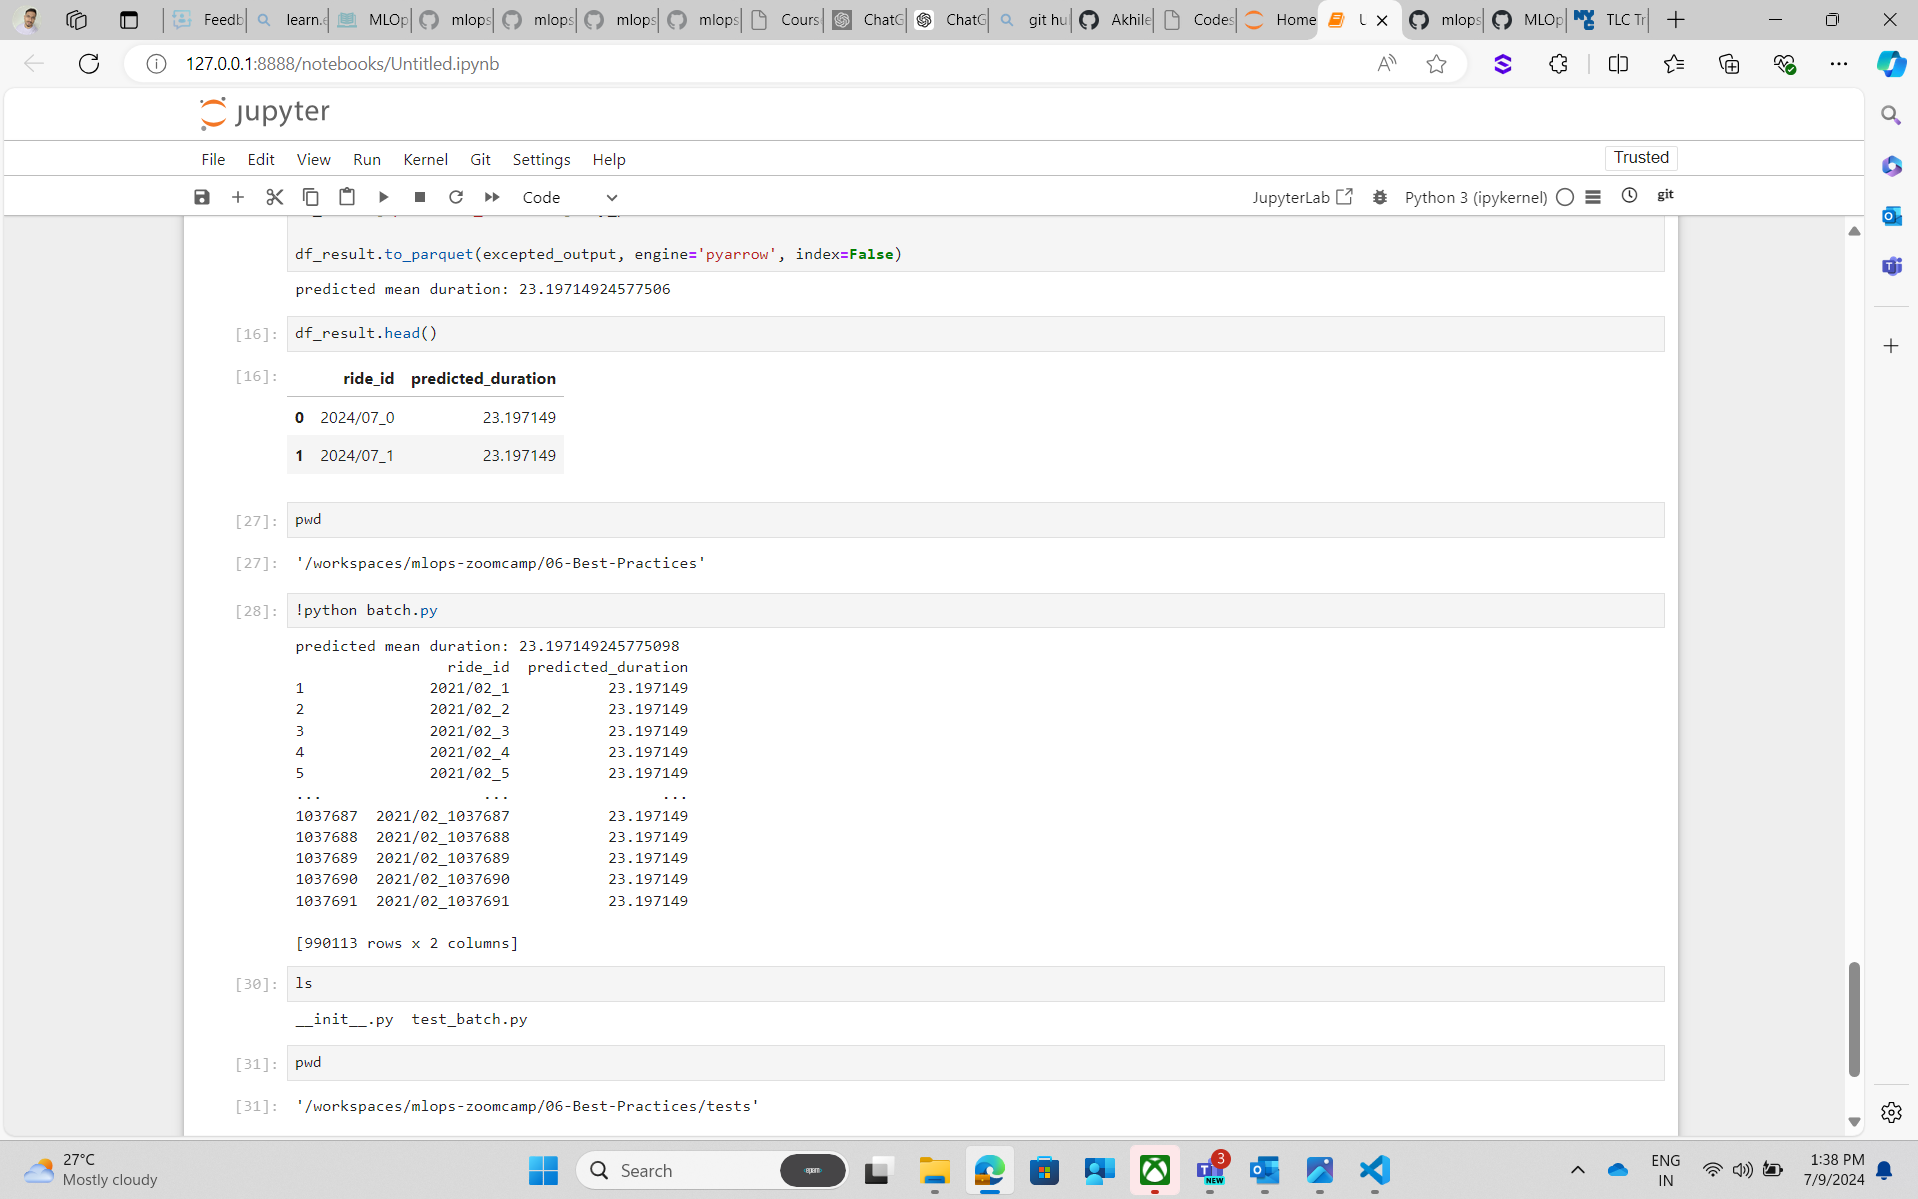

Answer: __init__.py 